In [16]:
h1 = pyfits.open('pohl_hi/decon-hi-nhli-clean-170K.fit')
h2 = pyfits.open('pohl_hi/decon-hi-gp-cor-clean-170K.fit')
h3 = pyfits.open('pohl_hi/decon-hi-phli-clean-170K.fit')

In [17]:
#print h1[0].header.cards
print h3[0].header.cards




('SIMPLE', True, 'Written by IDL:  Thu Jun 17 10:56:28 2010')
('BITPIX', -32, 'IEEE single precision floating point')
('NAXIS', 3, 'number of data axes')
('NAXIS1', 280, 'length of data axis 1')
('NAXIS2', 721, 'length of data axis 2')
('NAXIS3', 161, 'length of data axis 3')
('CTYPE1', 'DISTANCE', 'axis type')
('CRVAL1', 50, 'longitude')
('CRPIX1', 1, 'ref pixel')
('CDELT1', 100, 'longitude increment')
('CROTA1', 0.0, 'longitude rotation')
('CUNIT1', 'PC', 'unit type')
('CTYPE2', 'Gal. lon.', 'axis type')
('CRVAL2', 180.0, 'latitude')
('CRPIX2', 1, 'ref pixel')
('CDELT2', -0.5, 'longitude increment')
('CROTA2', 0.0, 'latitude rotation')
('CUNIT2', 'DEG', 'unit type')
('CTYPE3', 'Gal. lat.', 'axis type')
('CRVAL3', 10.0, 'velocity')
('CRPIX3', 1, 'ref pixel')
('CDELT3', 0.5, 'velocity increment')
('CROTA3', 0.0, 'velocity rotation')
('CUNIT3', 'DEG', 'unit type')
('PROJ', 'FLAT', 'type of projection')
('SYSTEM', 'GALACTIC', 'coordinate system')
('BUNIT', 'K', 'map units')
('OBSTYP', 'L

In [29]:
from scipy.interpolate import RegularGridInterpolator


hdu1 = pyfits.open('pohl_hi/decon-hi-nhli-clean-170K.fit')
hdu2 = pyfits.open('pohl_hi/decon-hi-gp-cor-clean-170K.fit')
hdu3 = pyfits.open('pohl_hi/decon-hi-phli-clean-170K.fit')

R_solar = 8.5
nx,ny,nz = 1601,1601,321
#nx,ny,nz = 401,401,101
x,y,z = np.linspace(-20,20,nx), np.linspace(-20,20,nx), np.linspace(-4,4,nz)
mapcube = np.zeros(shape=(nz,ny,nx), dtype=np.float32)

data2 = hdu2[0].data
h2 = hdu2[0].header
b = np.linspace(-20, 20, h2['NAXIS3'])
l = np.linspace(-180., 180., float(h2['NAXIS2']))
d = np.linspace(h2['CRVAL1'], float(h2['CRVAL1']+h2['NAXIS1']*h2['CDELT1']), h2['NAXIS1']+1)[:-1]/1000.
rgi_gp = RegularGridInterpolator((b,l,d), data2,method='linear',bounds_error=False,fill_value=np.float32(0.0))


data1 = hdu1[0].data
h1 = hdu1[0].header
b = np.linspace(-90, -10, h1['NAXIS3'])
l = np.linspace(-180., 180., float(h1['NAXIS2']))
d = np.linspace(h1['CRVAL1'], float(h1['CRVAL1']+h1['NAXIS1']*h1['CDELT1']), h1['NAXIS1']+1)[:-1]/1000.
rgi_south = RegularGridInterpolator((b,l,d), data1,method='linear',bounds_error=False,fill_value=np.float32(0.0))


data3 = hdu3[0].data
h3 = hdu1[0].header
b = np.linspace(10, 90, h3['NAXIS3'])
l = np.linspace(-180., 180., float(h3['NAXIS2']))
d = np.linspace(h3['CRVAL1'], float(h3['CRVAL1']+h3['NAXIS1']*h3['CDELT1']), h3['NAXIS1']+1)[:-1]/1000.

# def reversedim(M,k=0):
#         idx = tuple((slice(None,None,-1) if ii == k else slice(None) 
#                 for ii in xrange(M.ndim)))
#         return M[idx]
# data3_rev = reversedim(data3,0)


rgi_north = RegularGridInterpolator((b,l,d), data3,method='linear',bounds_error=False,fill_value=np.float32(0.0))


from astropy.coordinates import cartesian_to_spherical as cts
def GetPos(x,y,z):
    r,b,l = cts(-(x-R_solar), y, z)
    return r, np.rad2deg(b), np.rad2deg(l)

for ix, xx in enumerate(x):
    print '\r Fraction Complete', ix/float(len(x)), 
    for iy, yy in enumerate(y):
        dd,bb,ll = GetPos(xx,yy,z)
        
        idx_n = np.where(bb>20)[0]
        idx_s = np.where(bb<-20)[0]
        idx_gp= np.where( (bb<10) & (bb>-10) )[0]
        
        if idx_n != []:
            mapcube[idx_n,iy,ix] = rgi_north((bb[idx_n],ll,dd[idx_n]))
        if idx_s != []:
            mapcube[idx_s,iy,ix] = rgi_south((bb[idx_s],ll,dd[idx_s]))
        if idx_gp != []:
            mapcube[idx_gp,iy,ix] = rgi_gp((bb[idx_gp],ll,dd[idx_gp]))
            
        
        # Now interpolated regions
        idx_n_interp = np.where( (bb<20) & (bb>10))[0]
        idx_s_interp = np.where( (bb<-10) & (bb>-20))[0]
        
        if idx_s_interp != []:
            weights = -(bb[idx_s_interp]+10)/10. # 0 at b=-10, 1 at b=-20
            mapcube[idx_s_interp,iy,ix] = ( (1-weights)*rgi_gp((bb[idx_s_interp],ll,dd[idx_s_interp])) 
                                          + weights*rgi_south((bb[idx_s_interp],ll,dd[idx_s_interp]))) 
                                           
        if idx_n_interp != []:
            weights = (bb[idx_n_interp]-10)/10. # 0 at b=10, 1 at b=20
            mapcube[idx_n_interp,iy,ix] = ( (1-weights)*rgi_gp((bb[idx_n_interp],ll,dd[idx_n_interp])) 
                                          + weights*rgi_north((bb[idx_n_interp],ll,dd[idx_n_interp])) )

            

            
            
mapcube = np.clip(mapcube, 0, None)/100.
        
    

# for ib, b_pos in enumerate(b):
#     for il, l_pos in enumerate(y):
#         xx = R_solar-d*np.cos(l)*np.cos(b)
#         yy = -d*np.sin(l)*np.cos(b)
#         zz = d*sin(b)
#         ix,iy,iz = np.argmin(np.abs(x-xx)), np.argmin(np.abs(y-yy)), np.argmin(np.abs(z-zz))
#         idx = np.where(ix<)
        
        

 Fraction Complete 0.999375390381


In [30]:
mapcube2 = mapcube.copy()

rgi = RegularGridInterpolator((z,y,x), mapcube,method='linear',bounds_error=False,fill_value=np.float32(0.0))

correct_idx = np.where((z<.5) & (z>-.5))[0]


r_interp = np.linspace(0,20,40)
theta_interp1 = np.linspace(-165,-160,10)
theta_interp2 = np.linspace(160,165,10)

avg1 = []
avg2 = [] 

for r_big in r_interp:
    xx,yy = r_big*np.cos(theta_interp1), r_big*np.sin(theta_interp1)
    ring_avg = np.average([rgi((z,yy[i],xx[i])) for i in range(len(xx))],axis=0)
    avg1.append(ring_avg)
    
    xx,yy = r_big*np.cos(theta_interp2), r_big*np.sin(theta_interp2)
    ring_avg = np.average([rgi((z,yy[i],xx[i])) for i in range(len(xx))],axis=0)
    avg2.append(ring_avg)
    
rgi_r_theta1 = RegularGridInterpolator((r_interp,z), avg1, method='linear',
                                      bounds_error=False,fill_value=np.float32(0.0))
rgi_r_theta2 = RegularGridInterpolator((r_interp,z), avg2, method='linear',
                                      bounds_error=False,fill_value=np.float32(0.0))

for ix, xx in enumerate(x):
    print '\r Correcting Artifacts. Fraction Complete', ix/float(len(x)), 
    for iy, yy in enumerate(y):
        
        r_little = np.sqrt((xx-R_solar/1.8)**2 + yy**2)
        theta_little = np.rad2deg(np.arctan2(yy,xx-R_solar/2.))
        # Check if we lie near the circle.
        if (r_little < R_solar/2.1 + .07*R_solar) and (r_little > R_solar/2.1-.07*R_solar):
            if ((theta_little>25 and theta_little<155) or 
                (theta_little<-25 and theta_little>-155)):
                #mapcube2[:,iy,ix] = 0
                
                # If we are in the artifact region, interpolate from the sides.
                theta_big = np.arctan2(yy,xx)
                r_big = np.sqrt(yy**2+xx**2)
                
                x1,y1 = r_big*np.cos(theta_big-np.deg2rad(15)), r_big*np.sin(theta_big-np.deg2rad(15))
                x2,y2 = r_big*np.cos(theta_big+np.deg2rad(15)), r_big*np.sin(theta_big+np.deg2rad(15))
                mapcube2[correct_idx,iy,ix] = .5*(rgi((z[correct_idx],y1,x1))+rgi((z[correct_idx],y2,x2)))
        
        
            
#         r_big = np.sqrt(yy**2+xx**2)
#         theta_big = np.rad2deg(np.arctan2(yy,xx))
#         if r_big>8 and xx<0:
#             if theta_big>170 or theta_big<-170:
                
#                 r_big = np.sqrt(yy**2+xx**2)
#                 c1 = (theta_big-170)/40.
#                 c2 = 1-c1
#                 mapcube2[:,iy,ix] = c1*rgi_r_theta1((r_big,z)) + c2*rgi_r_theta2((r_big,z))
            
        

 Correcting Artifacts. Fraction Complete 0.999375390381


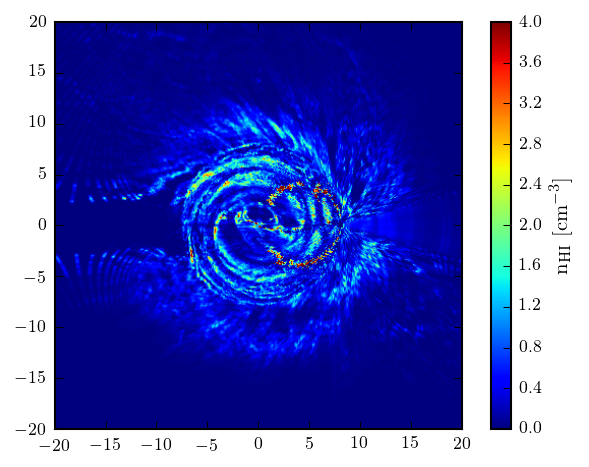

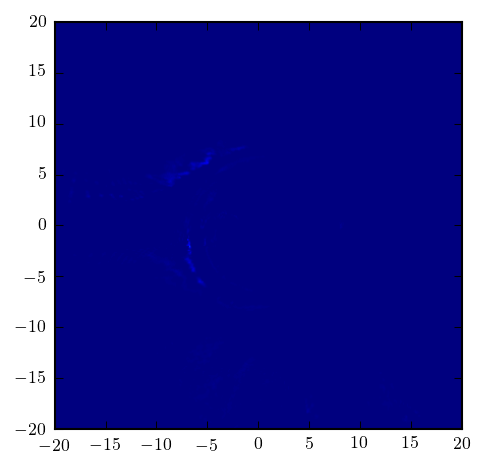

In [274]:
plt.imshow(mapcube[80], origin='lower',extent=[-20,20,-20,20], vmax=4)
#plt.imshow(np.sum(mapcube,axis=0), origin='lower',extent=[-15,15,-15,15], vmax=30)
plt.colorbar(label=r'$\rm n_{HI}\ [cm^{-3}]$')
plt.show()
plt.imshow(mapcube2[150], origin='lower',extent=[-20,20,-20,20], vmax=4)

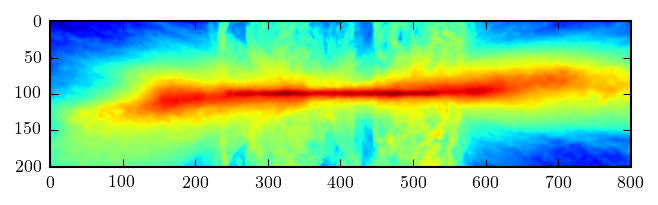

In [13]:
plt.imshow(np.log10(np.sum(mapcube,axis=2)))

In [31]:
hdu = pyfits.PrimaryHDU(mapcube.astype(np.float32))

hdu.header['CTYPE1'] = 'x in kpc'
hdu.header['CTYPE2'] = 'y in kpc'
hdu.header['CTYPE3'] = 'z in kpc'
hdu.header['CRVAL1'] = np.min(x)
hdu.header['CRVAL2'] = np.min(y)
hdu.header['CRVAL3'] = np.min(z)
hdu.header['CDELT1'] = round(x[1]-x[0],6)
hdu.header['CDELT2'] = round(y[1]-y[0],6)
hdu.header['CDELT3'] = round(z[1]-z[0],6)
hdu.header.add_comment('Generated by Eric Carlson using maps from Martin Pohl. No artifact correction')
hdu.header.add_comment('Units now in HI/cm^3.  Earth is at (8.5,0,0) kpc with -y for positive longitudes. ') 
hdulist = pyfits.HDUList([hdu,])
hdulist.writeto('HI_Pohl_galprop_8500_no_corr.fits',clobber=True)
hdulist.writeto('/data/galprop2/FITS/HI_Pohl_galprop_8500_no_corr.fits',clobber=True)
hdulist[0].header.cards



hdu = pyfits.PrimaryHDU(mapcube2.astype(np.float32))
hdu.header['CTYPE1'] = 'x in kpc'
hdu.header['CTYPE2'] = 'y in kpc'
hdu.header['CTYPE3'] = 'z in kpc'
hdu.header['CRVAL1'] = np.min(x)
hdu.header['CRVAL2'] = np.min(y)
hdu.header['CRVAL3'] = np.min(z)
hdu.header['CDELT1'] = round(x[1]-x[0],6)
hdu.header['CDELT2'] = round(y[1]-y[0],6)
hdu.header['CDELT3'] = round(z[1]-z[0],6)
hdu.header.add_comment('Generated by Eric Carlson using maps from Martin Pohl, along with')
hdu.header.add_comment('correction of artifacts due to forbidden velocities.')
hdu.header.add_comment('Units now in HI/cm^3.  Earth is at (8.5,0,0) kpc with -y for positive longitudes. ') 
hdulist = pyfits.HDUList([hdu,])
hdulist.writeto('HI_Pohl_galprop_8500.fits',clobber=True)
hdulist.writeto('/data/galprop2/FITS/HI_Pohl_galprop_8500.fits',clobber=True)
hdulist[0].header.cards


('SIMPLE', True, 'conforms to FITS standard')
('BITPIX', -32, 'array data type')
('NAXIS', 3, 'number of array dimensions')
('NAXIS1', 1601, '')
('NAXIS2', 1601, '')
('NAXIS3', 321, '')
('EXTEND', True, '')
('CTYPE1', 'x in kpc', '')
('CTYPE2', 'y in kpc', '')
('CTYPE3', 'z in kpc', '')
('CRVAL1', -20.0, '')
('CRVAL2', -20.0, '')
('CRVAL3', -4.0, '')
('CDELT1', 0.025, '')
('CDELT2', 0.025, '')
('CDELT3', 0.025, '')
('COMMENT', 'Generated by Eric Carlson using maps from Martin Pohl, along with', '')
('COMMENT', 'correction of artifacts due to forbidden velocities.', '')
('COMMENT', 'Units now in HI/cm^3.  Earth is at (8.5,0,0) kpc with -y for positive lo', '')
('COMMENT', 'ngitudes.', '')

In [231]:
# hdu = pyfits.PrimaryHDU(mapcube/(8.5/8.)**3)

# hdu.header['CTYPE1'] = 'x in kpc'
# hdu.header['CTYPE2'] = 'y in kpc'
# hdu.header['CTYPE3'] = 'z in kpc'
# hdu.header['CRVAL1'] = np.min(x)*8.5/8.
# hdu.header['CRVAL2'] = np.min(y)*8.5/8.
# hdu.header['CRVAL3'] = np.min(z)*8.5/8.
# hdu.header['CDELT1'] = round(x[1]-x[0],6)*8.5/8.
# hdu.header['CDELT2'] = round(y[1]-y[0],6)*8.5/8.
# hdu.header['CDELT3'] = round(z[1]-z[0],6)*8.5/8.
# hdu.header.add_comment('Generated by Eric Carlson using maps from Martin Pohl. No artifact correction')
# hdu.header.add_comment('Units now in HI/cm^3.  Earth is at (8.5,0,0) kpc with -y for positive longitudes. ') 
# hdulist = pyfits.HDUList([hdu,])
# hdulist.writeto('HI_Pohl_galprop_8500_post_no_corr.fits',clobber=True)
# hdulist[0].header.cards



# hdu = pyfits.PrimaryHDU(mapcube2/(8.5/8.)**3)
# hdu.header['CTYPE1'] = 'x in kpc'
# hdu.header['CTYPE2'] = 'y in kpc'
# hdu.header['CTYPE3'] = 'z in kpc'
# hdu.header['CRVAL1'] = np.min(x)*8.5/8.
# hdu.header['CRVAL2'] = np.min(y)*8.5/8.
# hdu.header['CRVAL3'] = np.min(z)*8.5/8.
# hdu.header['CDELT1'] = round(x[1]-x[0],6)*8.5/8.
# hdu.header['CDELT2'] = round(y[1]-y[0],6)*8.5/8.
# hdu.header['CDELT3'] = round(z[1]-z[0],6)*8.5/8.
# hdu.header.add_comment('Generated by Eric Carlson using maps from Martin Pohl, along with')
# hdu.header.add_comment('correction of artifacts due to forbidden velocities.')
# hdu.header.add_comment('Units now in HI/cm^3.  Earth is at (8.5,0,0) kpc with -y for positive longitudes. ') 
# hdulist = pyfits.HDUList([hdu,])
# hdulist.writeto('HI_Pohl_galprop_8500_post.fits',clobber=True)
# hdulist[0].header.cards


('SIMPLE', True, 'conforms to FITS standard')
('BITPIX', -64, 'array data type')
('NAXIS', 3, 'number of array dimensions')
('NAXIS1', 401, '')
('NAXIS2', 401, '')
('NAXIS3', 161, '')
('EXTEND', True, '')
('CTYPE1', 'x in kpc', '')
('CTYPE2', 'y in kpc', '')
('CTYPE3', 'z in kpc', '')
('CRVAL1', -21.25, '')
('CRVAL2', -21.25, '')
('CRVAL3', -4.25, '')
('CDELT1', 0.10625000000000001, '')
('CDELT2', 0.10625000000000001, '')
('CDELT3', 0.053125000000000006, '')
('COMMENT', 'Generated by Eric Carlson using maps from Martin Pohl, along with', '')
('COMMENT', 'correction of artifacts due to forbidden velocities.', '')
('COMMENT', 'Units now in HI/cm^3.  Earth is at (8.5,0,0) kpc with -y for positive lo', '')
('COMMENT', 'ngitudes.', '')

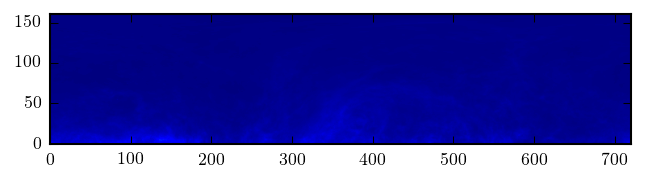

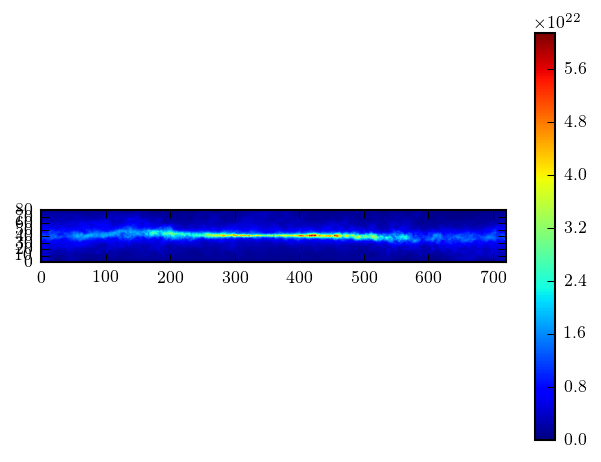

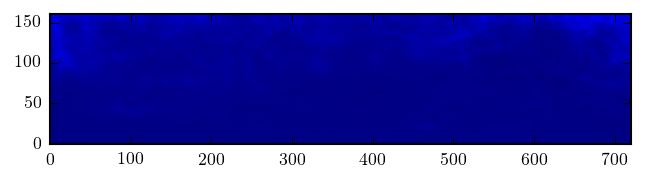

In [15]:
plt.imshow(np.sum(h3[0].data, axis=2), origin='lower', vmin=0,vmax=15000)
#plt.colorbar()
plt.show()

plt.imshow(np.sum(h2[0].data*3.08567758e18,axis=2), origin='lower', vmin=0,)
plt.colorbar()
plt.show()

plt.imshow(np.sum(h1[0].data, axis=2), origin='lower', vmin=0,vmax=15000)
#plt.colorbar()
plt.show()






<matplotlib.colorbar.Colorbar instance at 0x7feb976d03b0>

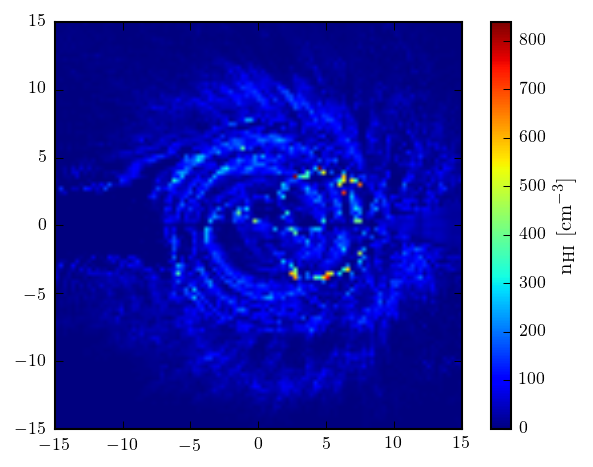

(0.0, 0.0, 180.0)
(2.5, 0.0, 126.86989764584402)
(81, 721, 380)


(0.1, 1000.0)

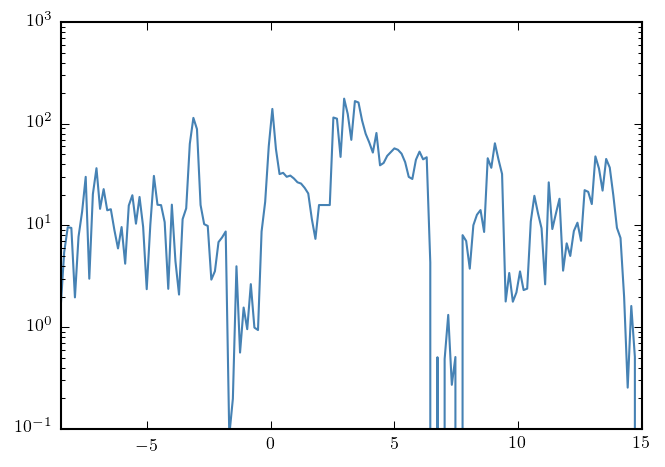

In [243]:
from astropy.coordinates import cartesian_to_spherical as cts
def GetPos(x,y,z):
    r,b,l = cts(-(x-R_solar), y, z)
    return r, np.rad2deg(b), (np.rad2deg(l))

print GetPos(8.5,0,0)



print GetPos(10,2,0)
print h2[0].data.shape
plt.plot(np.linspace(-8.5,380*.1+8.5, 380),h2[0].data[40,360,:])
plt.yscale('log')
plt.xlim(-8.5,15)
plt.ylim(1e-1,1e3)

[ 1.23086822  1.23093605  1.2711138  ...,  2.57834834  2.58470635
  2.58291983]


<matplotlib.colorbar.Colorbar instance at 0x7f023b1eb830>

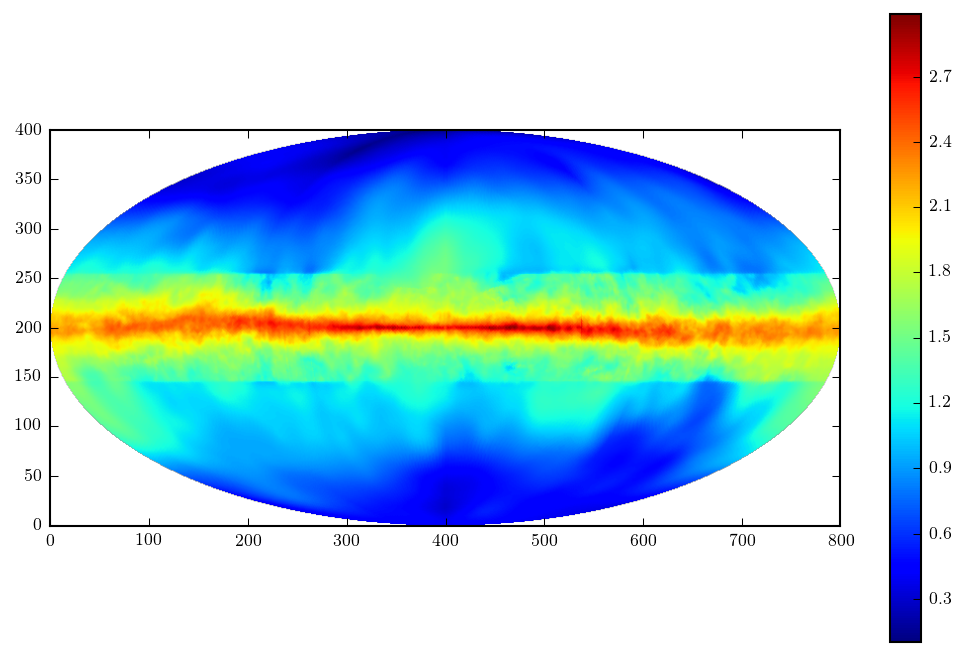

In [28]:
import healpy
def ReadFits(fname, length):
        d = pyfits.open(fname)[1].data
        return np.array([d.field(i) for i in range(length)])

    
d = ReadFits('/data/galprop2/output/pi0_decay_healpix_54_Pohl_HI_8500_no_corr_test.gz',38)[30]
print d
a = healpy.mollview(np.log10(d), return_projected_map=True)
plt.clf()
plt.imshow(a, origin='lower')
plt.colorbar()
#healpy.mollview(np.log10(ReadFits('/data/galprop2/output/healpix_54_NS_HI_8500_test.gz',38)[30]))

<matplotlib.colorbar.Colorbar instance at 0x7f023ad56488>

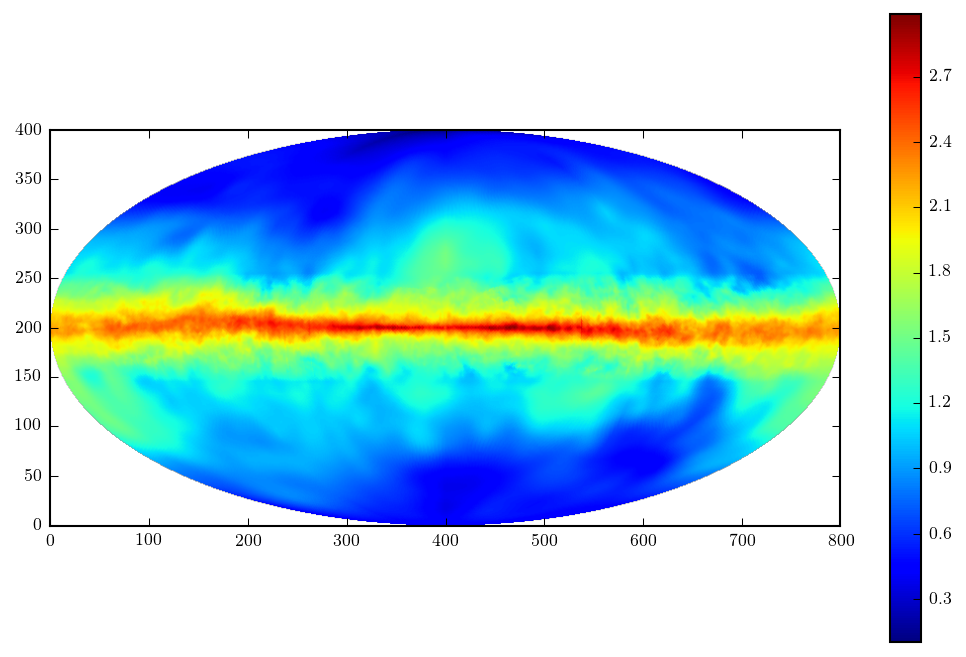

In [34]:
import healpy
def ReadFits(fname, length):
        d = pyfits.open(fname)[1].data
        return np.array([d.field(i) for i in range(length)])

    
d1 = ReadFits('/data/galprop2/output/pi0_decay_healpix_54_Pohl_HI_8500_no_corr_test.gz',38)[30]
a = healpy.mollview(np.log10(d1), return_projected_map=True)
plt.clf()
plt.imshow(a, origin='lower')
plt.colorbar()
#healpy.mollview(np.log10(ReadFits('/data/galprop2/output/healpix_54_NS_HI_8500_test.gz',38)[30]))

<matplotlib.colorbar.Colorbar instance at 0x7f023aa3fe18>

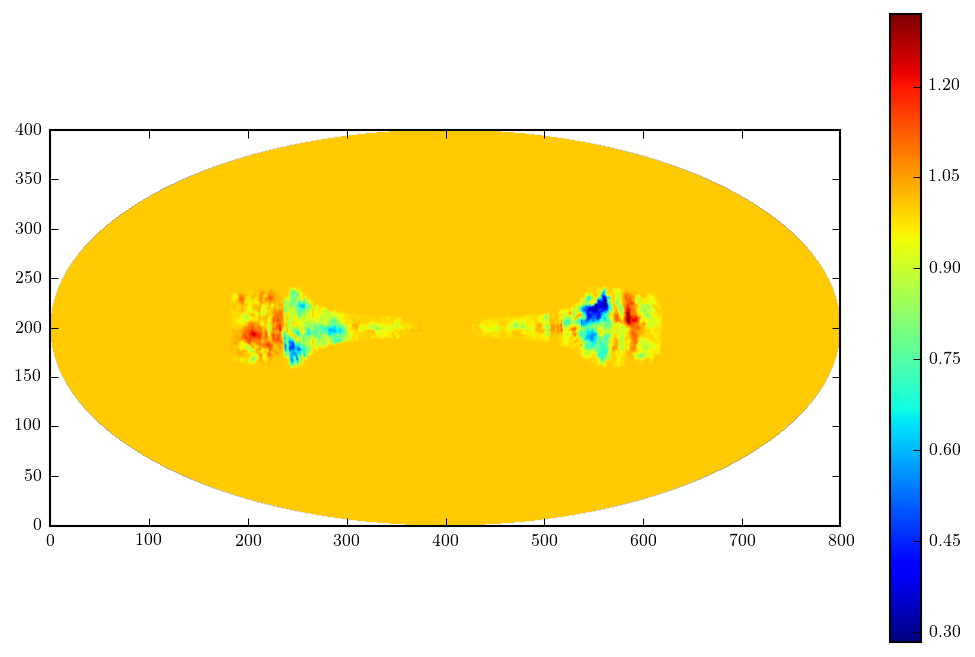

In [35]:
import healpy
def ReadFits(fname, length):
        d = pyfits.open(fname)[1].data
        return np.array([d.field(i) for i in range(length)])

    
d2 = ReadFits('/data/galprop2/output/pi0_decay_healpix_54_Pohl_HI_8500_test.gz',38)[30]
print 
a = healpy.mollview(d2/d1, return_projected_map=True)
plt.clf()
plt.imshow(a, origin='lower')
plt.colorbar()
#healpy.mollview(np.log10(ReadFits('/data/galprop2/output/healpix_54_NS_HI_8500_test.gz',38)[30]))